In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
#%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [5]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))

In [6]:
pdf

,date,month,year,area,70area,minlon,minlat,maxlon,maxlat,clon,clat,tmin,tmean,t10,t90
1983-01-01_18:00:00_1,1983-01-01 18:00:00,1,1983,142,29,6.130005,-3.989998,7.110001,-3.290001,6.620003,-3.639999,-74.709991,-63.825211,-71.069992,-71.069992
1983-01-01_18:00:00_2,1983-01-01 18:00:00,1,1983,238,8,14.180008,-3.150002,15.369995,-0.909996,14.775002,-2.029999,-78.479996,-59.464657,-66.189987,-66.189987
1983-01-01_18:00:00_3,1983-01-01 18:00:00,1,1983,161,2,3.750000,-2.099998,4.869995,-1.120003,4.309998,-1.610001,-71.069992,-59.452045,-66.189987,-66.189987
1983-01-01_18:00:00_4,1983-01-01 18:00:00,1,1983,91,34,17.539993,-1.959999,18.240005,-1.120003,17.889999,-1.540001,-87.659988,-66.334610,-74.709991,-74.709991
1983-01-03_18:00:00_1,1983-01-03 18:00:00,1,1983,123,0,13.199997,-3.220001,14.110001,-2.309998,13.654999,-2.764999,-62.149994,-55.665604,-60.439987,-60.439987
1983-01-03_18:00:00_2,1983-01-03 18:00:00,1,1983,341,0,18.729996,-2.940002,19.990005,-0.980003,19.360001,-1.960003,-68.589996,-56.809200,-62.149994,-62.149994
1983-01-08_18:00:00_1,1983-01-08 18:00:00,1,1983,124,0,-2.970001,-0.909996,-1.779999,-0.209999,-2.375000,-0.559998,-57.519989,-52.702808,-55.049988,-55.049988
1983-01-11_18:00:00_1,1983-01-11 18:00:00,1,1983,265,0,12.570007,-3.989998,14.669998,-3.080002,13.620003,-3.535000,-68.549988,-61.303165,-66.919998,-66.919998
1983-01-11_18:00:00_2,1983-01-11 18:00:00,1,1983,503,0,-11.720001,-1.820000,-8.569992,0.000000,-10.144997,-0.910000,-66.919998,-57.201866,-64.209991,-64.209991
1983-01-12_18:00:00_3,1983-01-12 18:00:00,1,1983,297,0,16.000000,-3.989998,18.589996,-3.220001,17.294998,-3.605000,-69.979996,-55.886627,-64.209991,-64.209991


In [7]:
pdf_march = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 3) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_march = pdf_march.dropna()

In [8]:
pdf_oct = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12) &
(pdf.month == 10) & (pdf.year >=2000) & (pdf.year <=2012))
pdf_oct = pdf_oct.dropna()

In [9]:
era_pl = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/pressure_levels/*.nc')
era_srfc = xr.open_mfdataset('/home/ck/DIR/mymachine/ERA5/surface/*.nc')

In [10]:
era_pl['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_pl['time.year'].values,era_pl['time.month'].values,era_pl['time.hour'].values)])
grouped='ymonth'
era_pl_mean =  era_pl.groupby(grouped).mean(dim='time')

In [11]:
era_srfc['ymonth'] = ('time', [str(y)+'-'+str(m)+'-'+str(h) for (y,m,h) in zip(era_srfc['time.year'].values,era_srfc['time.month'].values,era_srfc['time.hour'].values)])
grouped='ymonth'
era_srfc_mean =  era_srfc.groupby(grouped).mean(dim='time')

In [15]:
# era_out = get_ERA5(era_pl, era_srfc, pdf_march)
# pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'wb'))

In [15]:
era_clim_out = get_ERA5_clim(era_pl_mean, era_srfc_mean, pdf_oct)
pkl.dump(era_clim_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct_clim.p', 'wb'))

Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-01 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-02 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-03 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-04 18:00:00
Doing 2000-10-05 18:00:00
Doing 2000-10-05 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-06 18:00:00
Doing 2000-10-07 18:00:00
Doing 2000-10-07 18:00:00
Doing 2000-1

Doing 2002-10-01 18:00:00
Doing 2002-10-01 18:00:00
Doing 2002-10-01 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-02 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-03 18:00:00
Doing 2002-10-04 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-05 18:00:00
Doing 2002-10-06 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-07 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-08 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-09 18:00:00
Doing 2002-10-10 18:00:00
Doing 2002-10-10 18:00:00
Doing 2002-1

Doing 2003-10-20 18:00:00
Doing 2003-10-20 18:00:00
Doing 2003-10-20 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-21 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-22 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-23 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-24 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-25 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-26 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-10-27 18:00:00
Doing 2003-1

Doing 2005-10-13 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-14 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-15 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-16 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-17 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-10-18 18:00:00
Doing 2005-1

Doing 2007-10-07 18:00:00
Doing 2007-10-08 18:00:00
Doing 2007-10-08 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-09 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-10 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-11 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-12 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-10-13 18:00:00
Doing 2007-1

Doing 2009-10-01 18:00:00
Doing 2009-10-01 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-02 18:00:00
Doing 2009-10-03 18:00:00
Doing 2009-10-03 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-04 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-05 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-06 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-07 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-08 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-09 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-10-10 18:00:00
Doing 2009-1

Doing 2010-10-29 18:00:00
Doing 2010-10-29 18:00:00
Doing 2010-10-29 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-30 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2010-10-31 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-01 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-02 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-10-03 18:00:00
Doing 2011-1

Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-21 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-22 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-23 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-24 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-25 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-10-26 18:00:00
Doing 2012-1

In [65]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))

In [66]:
era_oct['dates'][2095]

Timestamp('2011-10-31 18:00:00')

In [67]:
level = era_march.pop('level')
level = era_oct.pop('level')

In [68]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [69]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [70]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [71]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

In [72]:
era_march.keys()

dict_keys(['q_col', 'tcwv', 'lat', 'dates', 'lon', 't10', 'tmin', 'CAPE', 'u650', 'r_col', 'u925', 'area', 'tmean', 'q700', 'area70', 'u_col', 'q925', 'v_col'])

In [117]:
era_march['q_col']

[array([4.4280430e-05, 7.7767894e-05, 1.8003216e-04, 1.7923854e-04,
        2.4918930e-04, 9.2492264e-04, 1.2385355e-03, 2.6060801e-03,
        3.6397097e-03, 5.4479148e-03, 6.3751959e-03, 8.6934995e-03,
        1.2038637e-02, 1.3164694e-02, 1.4135914e-02, 1.5163069e-02,
        1.6227465e-02, 1.6607624e-02, 1.6818756e-02], dtype=float32),
 array([3.67743596e-05, 2.26307762e-04, 2.08815996e-04, 3.78063385e-04,
        7.92551902e-04, 1.50122703e-03, 2.29905592e-03, 2.93630874e-03,
        3.56230303e-03, 5.11213904e-03, 5.43854898e-03, 7.42198620e-03,
        1.15026319e-02, 1.29728382e-02, 1.39397485e-02, 1.48678487e-02,
        1.61144026e-02, 1.66979115e-02, 1.69635192e-02], dtype=float32),
 array([4.3346157e-05, 5.9446476e-05, 7.7321456e-05, 1.4971782e-04,
        1.5233418e-04, 2.3655890e-04, 1.4188053e-03, 2.1491002e-03,
        2.6346978e-03, 3.0037328e-03, 5.2559632e-03, 7.5962874e-03,
        1.1004757e-02, 1.2579923e-02, 1.3882024e-02, 1.5092235e-02,
        1.6155653e-02, 1.

In [131]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    sort = np.argsort(q925)
    q = q925[sort]
    shear = (np.array(dic['u650'])-np.array(dic['u925']))[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,20)
    inds = np.round(linsp).astype(int)
    
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q*1000)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):
    
        qmean.append(np.mean(q[start:end]))
        corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
        qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  
    return qmean, corr, qcorr

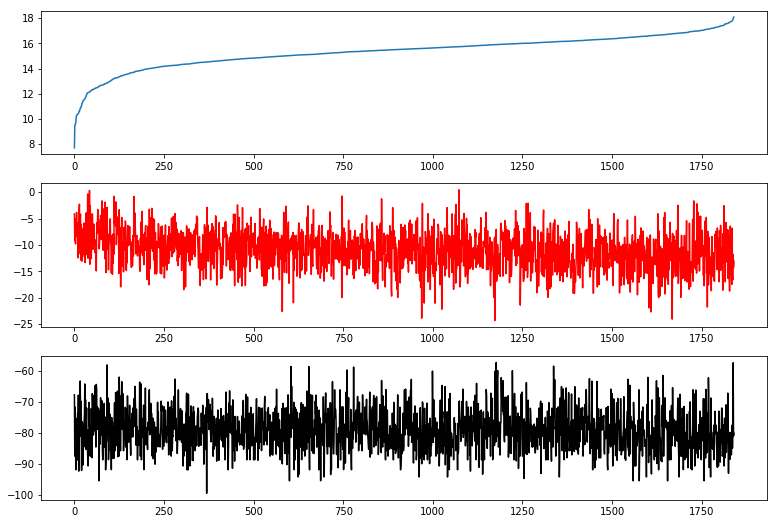

In [132]:
qmean_march, corr_march, qcorr_march = sort_vars(era_march)

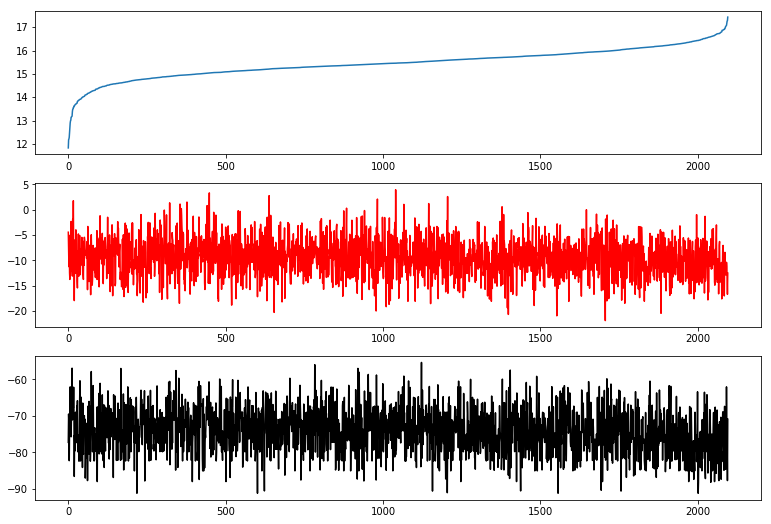

In [133]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(era_oct)

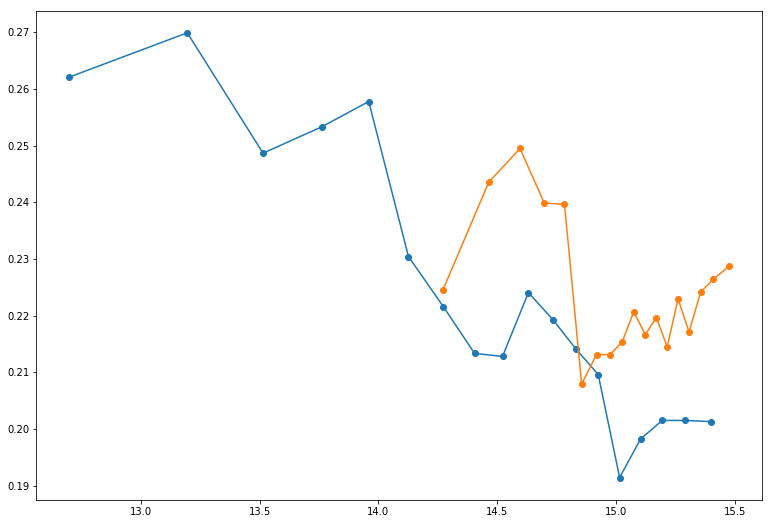

In [134]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march)*1000,corr_march, '-o')
plt.plot(np.array(qmean_oct)*1000,corr_oct, '-o')

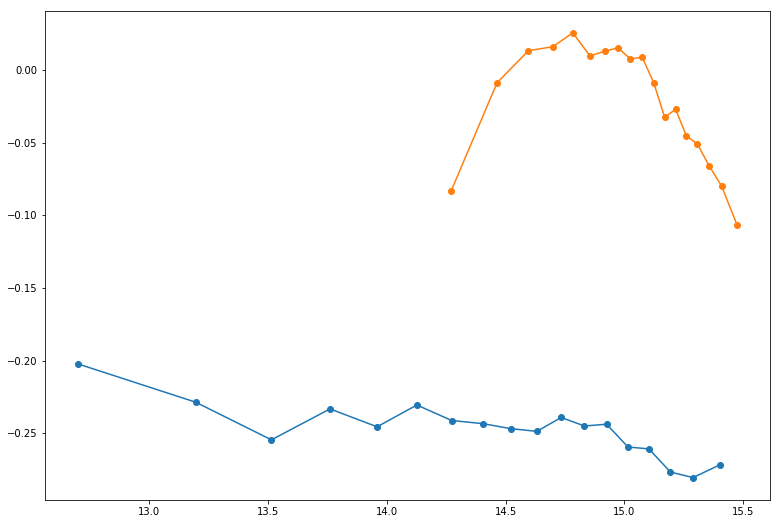

In [135]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march)*1000,qcorr_march, '-o')
plt.plot(np.array(qmean_oct)*1000,qcorr_oct, '-o')